In [2]:
import csv
import codecs
import math
from urllib.request import urlopen
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt


Ingrese el nombre del archivo: bayg29


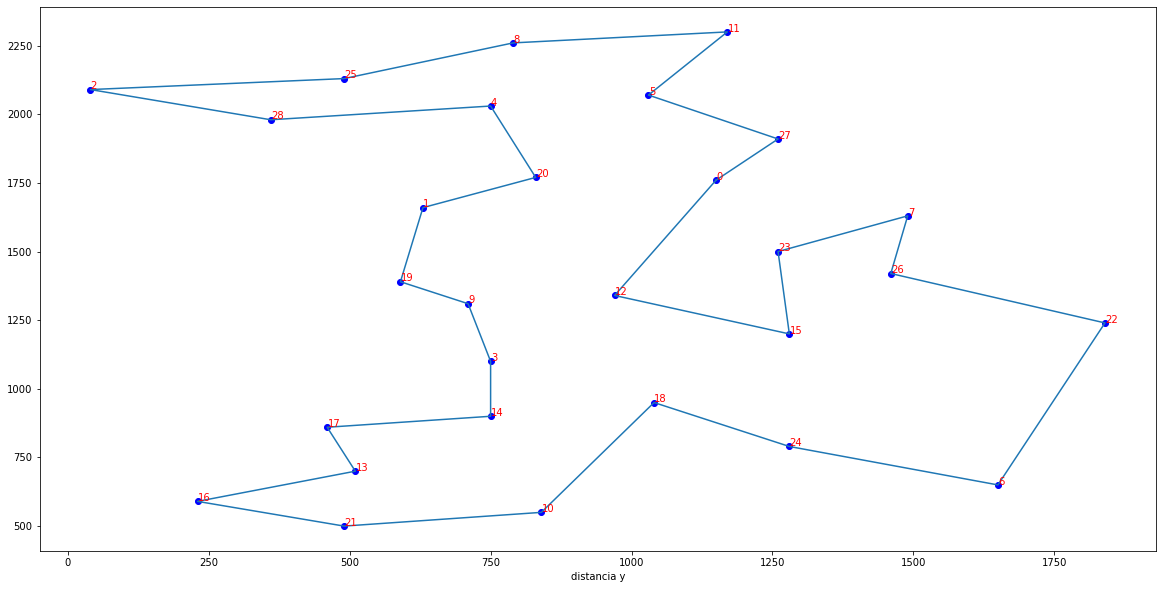

[0, 27, 5, 11, 8, 25, 2, 28, 4, 20, 1, 19, 9, 3, 14, 17, 13, 16, 21, 10, 18, 24, 6, 22, 26, 7, 23, 15, 12, 0]
Coste total: 9082


In [5]:
def modelo_de_datos(name):
    """Genera los datos del problema
    
    :param indices: nombre del archivo
    :return: diccionario con las coordenadas x y y, coordenadas en x y y
    
    """
    
    coord_x=[]
    coord_y=[]
    
    #Abrimos el archivo y extraemos las coordenadas x y y en un array
    with urlopen("http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/" + name + ".tsp") as f:
            reader = csv.reader(codecs.iterdecode(f, 'utf-8'), delimiter=" ", skipinitialspace=True)
        
            for row in reader:
                if row[0] in ('DISPLAY_DATA_SECTION', 'NODE_COORD_SECTION'):
                    break

           
            for row in reader:
                if row[0] != 'EOF':
                    # eliminar el índice al principio de la línea
                    del row[0]

                    # convierte las coordenadas x,y en ndarray:
                    coord_x.append(float(row[0]))
                    coord_y.append(float(row[1]))
                else:
                    break
        
    data = {}
    #Genera la matriz de coordenadas
    data['locations'] = [(coord_x[i], coord_y[i]) for i in range(len(coord_x))]
    
    data['num_man'] = 1
    data['depot'] = 0
    return data,coord_x,coord_y


def calcular_matriz_distancia(locations):
    """Encuentra la distancia entra cada punto
    
    :param indices: matriz de coordenadas (x,y)
    :return: distancia entre nodos
    """
    distances = {}
    for i, nodo1 in enumerate(locations):
        distances[i] = {}
        for j, nodo2 in enumerate(locations):
            if i == j:
                distances[i][j] = 0
            else:
                # Distancia euclidiana
                distances[i][j] = (int(
                    math.hypot((nodo1[0] - nodo2[0]),
                               (nodo1[1] - nodo2[1]))))
    return distances


def solution(manager, routing, solucion):
    """Muestra la solución en la consola
    
    :param indices: indices de enrutamiento,modelo de enrutamiento,solucion del modelo de enrutamiento 
    :return: ruta
    
    """
    index = routing.Start(0)
    route_distance = 0
    #Lista en donde se almacena la ruta
    route=[]
    
    while not routing.IsEnd(index):
        #Agregamos el nodo correspondiente al índice.
        route.append(manager.IndexToNode(index))
        previous_index = index
        index = solucion.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    route.append(manager.IndexToNode(index))
    #Se agrega el Coste final
    route.append(route_distance)
    return route

    
def plotData(ruta,coord_x,coord_y):
    """traza la trayectoria descrita por los índices dados de las ciudades

       :param indices: ruta,coordenadas x y y
       :return: muestra la gráfica
    """
    # Ordena las coordenadas
    X=[]
    Y=[]
    for i in ruta[:-1]:
        X.append(coord_x[i])
        Y.append(coord_y[i])
    
    #Traza las coordenadas
    plt.figure(figsize=(20,10))
    plt.scatter(coord_x,coord_y,color='blue')
    plt.plot(X,Y)
    
    
    # Coloca una etiqueta en cada nodo
    for n in range(len(coord_x)):
        plt.annotate(str(n), xy=(coord_x[n],coord_y[n]),
                 xytext=(coord_x[n]+0.5,coord_y[n]+1),color='red')
    
    plt.xlabel("distancia x")
    plt.xlabel("distancia y")

    plt.show()

    return plt


def main():
    """Iniciamos el programa"""
    
    name=input("Ingrese el nombre del archivo: ")
    data,X,Y = modelo_de_datos(name)

    # Genera los indices de enrutamiento
    manager = pywrapcp.RoutingIndexManager(len(data['locations']),
                                           data['num_man'], data['depot'])

    # Crear modelo de enrutamiento
    routing = pywrapcp.RoutingModel(manager)

    matriz_distancia = calcular_matriz_distancia(data['locations']) # Obtiene la matriz de distancia
  
    #obtiene la distancia entra cada nodo
    def distancia_callback(index1, index2):
        """Retorna la distancia entre dos nodos"""
        node1 = manager.IndexToNode(index1) #Devuelve el nodo correspondiente al índice1
        node2 = manager.IndexToNode(index2)     #Devuelve el nodo correspondiente al índice2
        return matriz_distancia[node1][node2]

    transit_callback_index = routing.RegisterTransitCallback(distancia_callback)

    # Define el coste de cada arco.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Encuentra la primera solución
    paramet = pywrapcp.DefaultRoutingSearchParameters()
    paramet.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Resuelve el problema
    solucion = routing.SolveWithParameters(paramet)
    
    # Grafica la solución
    plot = plotData(solution(manager, routing, solucion),X,Y)
    plot.show()

    # Muestra la solución en la consola
    if solucion:
        r=solution(manager, routing, solucion)
        print(r[:-1])
        print('Coste total: {}'.format(r[-1]))
        

if __name__ == '__main__':
    main()
    